# From Cartool to MNE

## 0) Prepare data

#### 0.1) Import necessary packages 

In [1]:
import os
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd

import mne

import pycartool

#### 0.2) Set paths

In [2]:
# Path to data
datafold = "/home/localadmin/Documents/research/0_data/DS001_BIDS/"

# Path to EEGlab files
EEG_path = os.path.join(datafold,'derivatives','eeglab') 

# Path to leadfield matrices
IS_path = ''
# Path to save output figures

#### 0.3) Select subject

In [3]:
sub = 1
subject = str(sub).zfill(2)

# 1) Scalp analysis

#### 1.1) Load eeg data

Creating RawArray with float64 data, n_channels=128, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


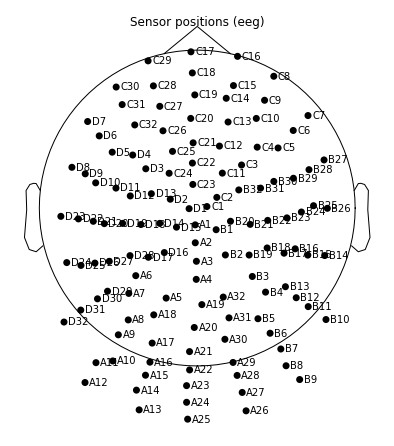

/home/localadmin/anaconda3/envs/eegtorch/lib/python3.6/site-packages/mne/externals/pymatreader/utils.py:118: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /home/localadmin/Documents/research/0_data/DS001_BIDS/derivatives/eeglab/sub-01/sub-01_FACES_250HZ_prepd.set...
Not setting metadata
Not setting metadata
588 matching events found
No baseline correction applied


<ipython-input-25-8a7716b0dc38>:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.read_epochs_eeglab(EEG_file, events=None, event_id=None, eog=(), verbose=None, uint16_codec=None)


0 projection items activated
Ready.
Applying baseline correction (mode: mean)
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...


<EpochsEEGLAB |  588 events (all good), -0.1 - 0.5 sec, baseline [0, None], ~87.1 MB, data loaded,
 '65344/FACES/65344/correct/65344/CONTROL/65344/correct/65344': 1
 '65344/correct/65344/CONTROL/65344/correct': 9
 '65344/correct/65344/CONTROL/65344/correct/65344': 27
 '65344/correct/65344/FACES/65344/correct': 7
 '65344/correct/65344/FACES/65344/correct/65344': 24
 'CONTROL/65344/correct/65344': 1
 'CONTROL/65344/correct/65344/CONTROL/65344/correct': 20
 'CONTROL/65344/correct/65344/CONTROL/65344/correct/65344': 102
 'CONTROL/65344/correct/65344/CONTROL/65344/error/65344': 1
 'CONTROL/65344/correct/65344/FACES/65344': 1
 'CONTROL/65344/correct/65344/FACES/65344/correct': 15
 'CONTROL/65344/correct/65344/FACES/65344/correct/65344': 112
 'CONTROL/65344/error/65344/FACES/65344/correct/65344': 1
 'FACES/65344/correct/65344': 3
 'FACES/65344/correct/65344/CONTROL/65344/correct': 12
 'FACES/65344/correct/65344/CONTROL/65344/correct/65344': 116
 'FACES/65344/correct/65344/FACES/65344/correct'

In [25]:
# Load EEG electrode locations and transformation matrix to the original space

fif_fname = os.path.join(datafold,'derivatives','mne','sub-'+subject,'sub-'+subject+'-montage.fif')
if False:#os.path.exists(fif_fname):
    montage = mne.channels.read_dig_fif(fif_fname)
else:
    montage_fname = os.path.join(datafold,'derivatives','Cartool-v3.80','sub-'+subject,'sub-'+subject+'.xyz')
    dev_head_t_fname = os.path.join(datafold,'derivatives','Cartool-v3.80','sub-'+subject,'More','sub-'+subject+'.Transform.Electrodes Coregistration.Electrodes to Realigned MRI.txt')
    dev_head_t = np.loadtxt(dev_head_t_fname)

    n = int(open(montage_fname).readline().lstrip().split(' ')[0])
    all_coord = np.loadtxt(montage_fname, skiprows=1, usecols=(0, 1, 2), max_rows=n)
    all_names = np.loadtxt(montage_fname, skiprows=1, usecols=3, max_rows=n,dtype=np.dtype(str)).tolist()
    all_coord = list(map(lambda x: x/1000,all_coord))
    #all_coord = list(map(lambda x: np.dot(dev_head_t[:3,:],np.concatenate((x,[1])))/1000,all_coord))
    
    ch_coord  = [all_coord[idx] for idx, chan in  enumerate(all_names) if chan not in ['lpa','rpa','nasion']]
    ch_names  = [all_names[idx] for idx, chan in  enumerate(all_names) if chan not in ['lpa','rpa','nasion']]
    
    
    if all([elem in all_names for elem in ['nasion','lpa','rpa']]):
        nas_coord = all_coord[all_names.index('nasion')]
        lpa_coord = all_coord[all_names.index('lpa')]
        rpa_coord = all_coord[all_names.index('rpa')]
        montage = mne.channels.make_dig_montage(ch_pos=dict(zip(ch_names, ch_coord)),nasion=nas_coord,rpa=rpa_coord,lpa=lpa_coord,coord_frame='head')
    else:
        montage = mne.channels.make_dig_montage(ch_pos=dict(zip(ch_names, ch_coord)),coord_frame='head')
         
    montage.dev_head_t = dev_head_t
    montage.save(fif_fname)

montage.plot();

# Path to EEGlab files
EEG_file = os.path.join(EEG_path,'sub-'+subject,'sub-'+subject+'_FACES_250HZ_prepd.set') 

epochs = mne.read_epochs_eeglab(EEG_file, events=None, event_id=None, eog=(), verbose=None, uint16_codec=None)
epochs.set_montage(montage)
epochs.apply_baseline((0,None))
epochs.set_eeg_reference('average',projection = True)
epochs.apply_proj()
epochs.crop(tmin=-0.1, tmax=.5)

#### 1.2) Load behavioral data

In [26]:
# Load epoch metadata into a table with header [COND, ACC, RT, nameCOND, outliers, bat_trials]
Behav_path = os.path.join(EEG_path,'sub-'+subject,'sub-'+subject+'_FACES_250HZ_behav.txt') 
Behavfile = pd.read_csv(Behav_path, sep=",")
Behavfile = Behavfile[Behavfile.bad_trials == 0]
epochs.events[:,2] = list(Behavfile.COND)
epochs.event_id = {"Scrambled":0, "Faces":1}

Scra_epochs =epochs['Scrambled']
Face_epochs = epochs['Faces']

#### 1.3) Plot scalp eeg data (GFP)

Not setting metadata
Not setting metadata
294 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "gfp"


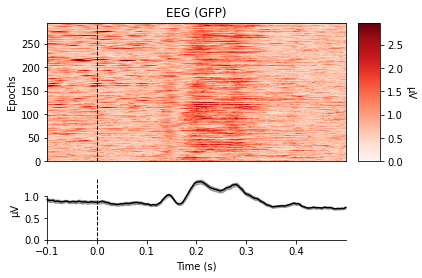

[<Figure size 432x288 with 3 Axes>]

In [27]:
#Scra_epochs.plot_image()
Face_epochs.plot_image()
# Check this out : https://mne.tools/stable/generated/mne.Epochs.html#mne.Epochs.plot_image

#### 1.4) Plot spectrum for different conditions

In [28]:
frequencies = np.arange(5, 80, 3)
#power_scra = mne.time_frequency.tfr_morlet(Scra_epochs, n_cycles=2, return_itc=False,
#                                      freqs=frequencies, decim=3)
power_faces = mne.time_frequency.tfr_morlet(Face_epochs, n_cycles=2, return_itc=False,
                                      freqs=frequencies, decim=3)

ValueError: At least one of the wavelets is longer than the signal. Use a longer signal or shorter wavelets.

No baseline correction applied


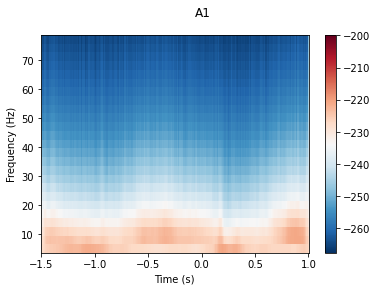

No baseline correction applied


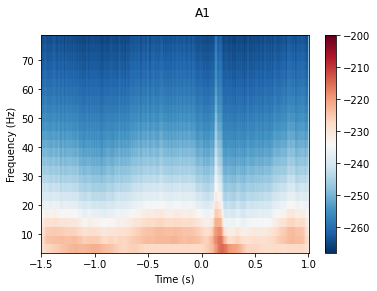

In [15]:
#power_scra.plot(dB='True',vmax = -200)
power_faces.plot(dB='True',vmax = -200);

#### 1.5) Different ERP plots

combining channels using "gfp"
combining channels using "gfp"


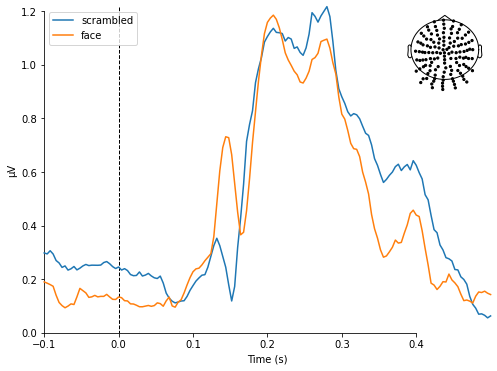

In [31]:
scra_evoked = Scra_epochs.average()
face_evoked = Face_epochs.average()

mne.viz.plot_compare_evokeds(dict(scrambled=scra_evoked, face=face_evoked),
                             legend='upper left', show_sensors='upper right');

Projections have already been applied. Setting proj attribute to True.


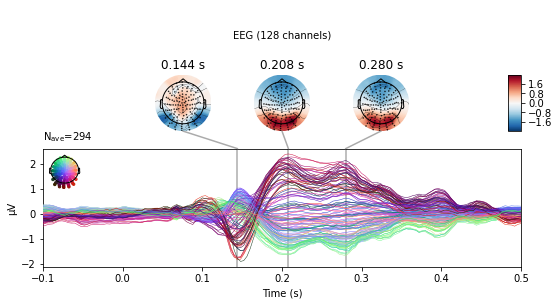

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [47]:
fig = face_evoked.plot_joint();
fig.savefig('/home/localadmin/Documents/research/3_archive/Connectome_Harmonics_VEP/figures/sc_num/F0/plot_join.eps',format='eps')

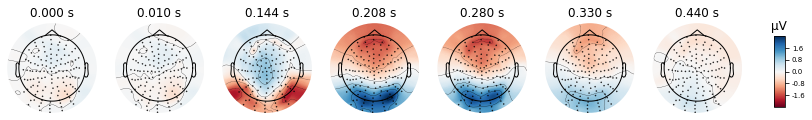

In [54]:
#fig = face_evoked.plot_topomap([.0,.010,.144,.208,.280,.33,.44],cmap='magma');
fig = face_evoked.plot_topomap([.0,.010,.144,.208,.280,.33,.44],cmap='RdBu');
fig.savefig('/home/localadmin/Documents/research/3_archive/Connectome_Harmonics_VEP/figures/sc_len/F0/plot_topomap.eps',format='eps')


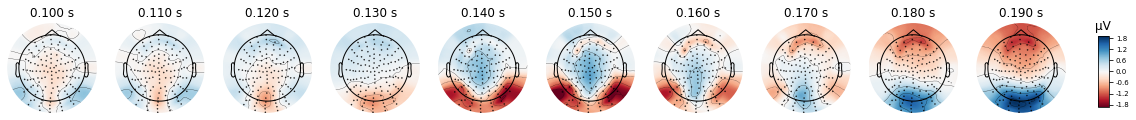

In [59]:
fig = face_evoked.plot_topomap(np.arange(0.1,0.2,0.01),cmap='RdBu');

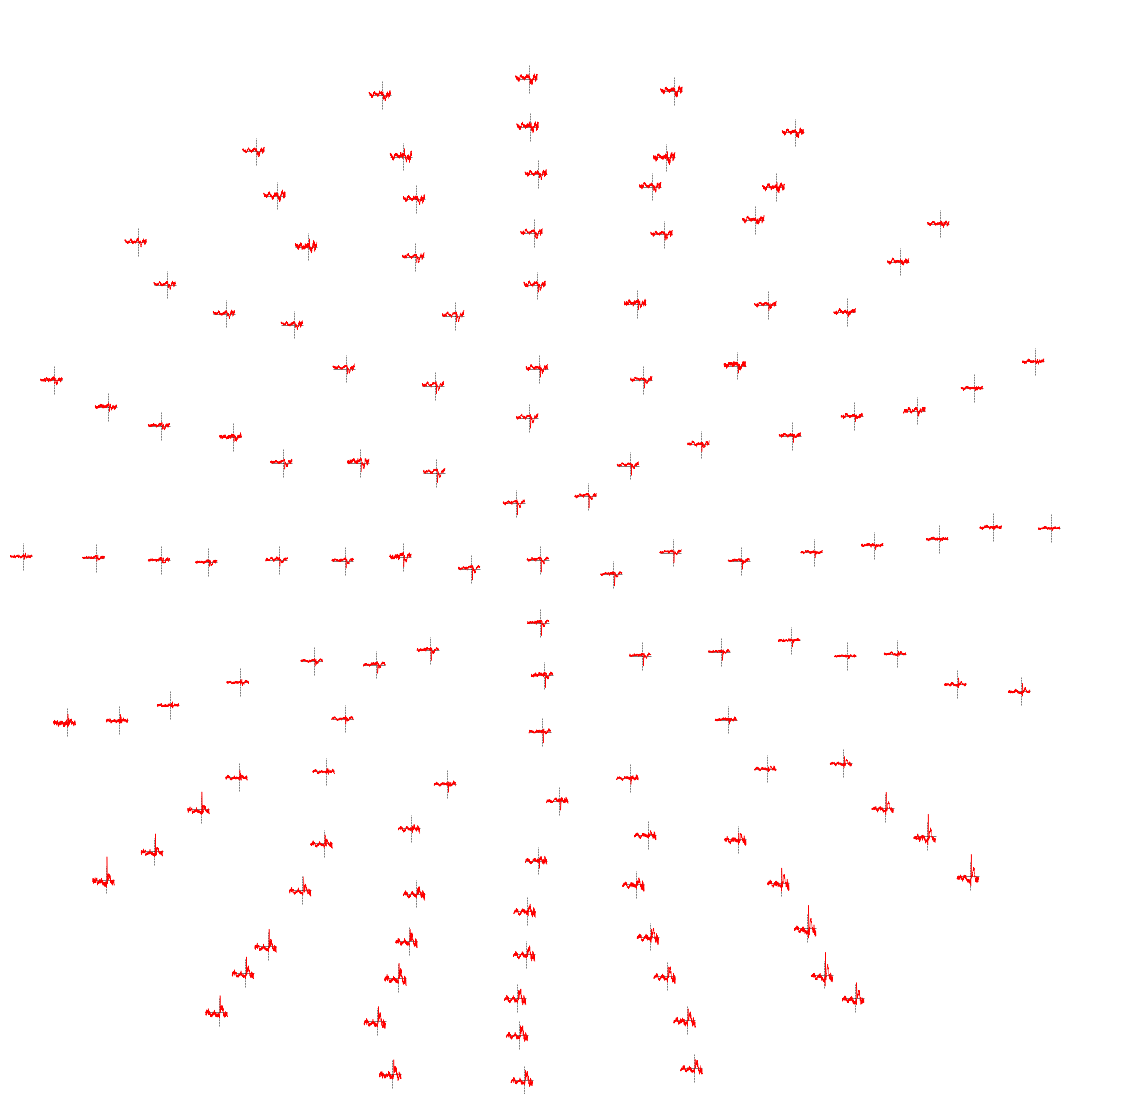

In [18]:
fig, axs = plt.subplots(figsize=(20,20))
evoked_diff = mne.combine_evoked([scra_evoked, -face_evoked], weights='equal')
evoked_diff.plot_topo(color='r', legend=False,axes = axs ,ylim ={'eeg':[-1,1]});

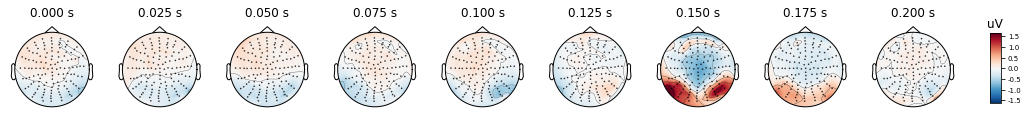

In [19]:
evoked_diff.plot_topomap(times=[0., 0.025, 0.05, .075,0.10,.125,.15,0.175, 0.2], ch_type='eeg');

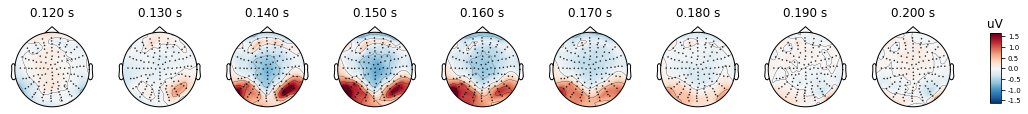

In [20]:
evoked_diff.plot_topomap(times=[.12,.13,.14,.15,.16,0.17,.18,.19,.2], ch_type='eeg');

"""
tmin = -100
tmax = 600

time_vec = np.where((EEGfile.times>=tmin/1000) & (EEGfile.times<=tmax/1000))[0]
time = EEGfile.times[time_vec]
data_plot = EEGdata[:,:,time_vec]

dt = time[1]-time[0]
trials0 = np.arange(np.sum(trials_cond0))
trials1 = np.arange(np.sum(trials_cond1))
channels = np.arange(len(EEGfile.ch_names))
extent0 = [time[0]-dt, time[-1]+dt, trials0[0]-1, trials0[-1]+1]
extent1 = [time[0]-dt, time[-1]+dt, trials1[0]-1, trials1[-1]+1]
extent2 = [time[0]-dt, time[-1]+dt, channels[0]-1, channels[-1]+1]


minval = np.min(EEGdata.mean(0).mean(0))
maxval = np.max(EEGdata.mean(0).mean(0))

fig,axs = plt.subplots(2,3,figsize=(20,25))
axs[0,0].imshow(data_plot[trials_cond0,:,:].mean(1),cmap='coolwarm',extent = extent0, aspect='auto')
axs[0,0].tick_params(axis='both', which='major', labelsize=20)
axs[0,0].set_xlabel('time [s]',fontsize=20)
axs[0,0].set_ylabel('Epoch',fontsize=20)
axs[0,0].set_title('Condition = 0',fontsize=20)
axs[0,0].axvline(x=0,color='k')

axs[0,1].imshow(data_plot[trials_cond1].mean(1),cmap='coolwarm',extent = extent1, aspect='auto')
axs[0,1].tick_params(axis='both', which='major', labelsize=20)
axs[0,1].set_ylabel('Epoch',fontsize=20)
axs[0,1].set_xlabel('time [s]',fontsize=20)
axs[0,1].set_title('Condition = 1',fontsize=20)
axs[0,1].axvline(x=0,color='k')

axs[0,2].imshow(data_plot[trials_cond1].mean(0)-data_plot[trials_cond0].mean(0),cmap='coolwarm',extent = extent2, aspect='auto')
axs[0,2].tick_params(axis='both', which='major', labelsize=20)
axs[0,2].set_ylabel('Electrode',fontsize=20)
axs[0,2].set_xlabel('time [s]',fontsize=20)
axs[0,2].set_title('Difference',fontsize=20)
axs[0,2].axvline(x=0,color='k')

axs[1,0].plot(time,data_plot[trials_cond0].mean(0).T,'grey',linewidth=.5)
axs[1,0].axvline(x=0,color='k')
axs[1,0].axhline(y=0,color='k')

axs[1,1].plot(time,data_plot[trials_cond1].mean(0).T,'grey',linewidth=.5)
axs[1,1].axvline(x=0,color='k')
axs[1,1].axhline(y=0,color='k')

axs[1,2].plot(time,data_plot[trials_cond1].mean(0).T-data_plot[trials_cond0].mean(0).T,'grey',linewidth=.5)
axs[1,2].axvline(x=0,color='k')
axs[1,2].axhline(y=0,color='k')


axs[2,0].plot(time,data_plot[trials_cond0].mean(0).T,'grey',linewidth=.5)
axs[2,0].axvline(x=0,color='k')
axs[2,0].axhline(y=0,color='k')

axs[2,1].plot(time,data_plot[trials_cond1].mean(0).T,'grey',linewidth=.5)
axs[2,1].axvline(x=0,color='k')
axs[2,1].axhline(y=0,color='k')

axs[2,2].plot(time,data_plot[trials_cond1].mean(0).T-data_plot[trials_cond0].mean(0).T,'grey',linewidth=.5)
axs[2,2].axvline(x=0,color='k')
axs[2,2].axhline(y=0,color='k')
"""



"""ax.plot(EEGfile.times,EEGdata[trials_cond0,5,:].T,'r',linewidth=0.1)
ax.plot(EEGfile.times,np.mean(EEGdata[trials_cond0,5,:],axis =0),'k')
ax.fill_between(EEGfile.times, np.percentile(EEGdata[trials_cond0,5,:],5,axis =0), np.percentile(EEGdata[trials_cond0,5,:],95,axis =0),
    alpha=0., edgecolor='k', facecolor='k')"""

# 2) Source analysis

#### 2.1) Source localization (using Cartool IS, project_dipoles_inv3D, SVD, and group_signflip)

In [21]:
# Loop across subjects
# get ROI parcellations index
roi_filename = os.path.join(datafold,'02_ESI_CARTOOL','CartoolFiles','sub-'+subject,'More','ROI_33','sub-'+subject+'.rois')
roi_file = pycartool.regions_of_interest.read_roi(roi_filename)
# get IS (Laura inverse solution)
is_filename = os.path.join(datafold,'02_ESI_CARTOOL','CartoolFiles','sub-'+subject,'sub-'+subject+'.Laura.is')
is_file = pycartool.io.inverse_solution.read_is(is_filename)

# load EEG data (all trials)
# compute inverse solutions for each ROI

IS = is_file['regularisation_solutions'][12]

RO01
Dimension_of_original_data: 5008
Number of ROI: 82
Reading /home/jo8558/data/SINERGIA_2019/02_ESI_CARTOOL/CartoolFiles/sub-01/sub-01.Laura.is
Reading Header...
IS type: IS03
n_channels: 131
n_solutionpoints: 5008
n_regularizations: 13
Inverse solution is Vectorial
Reading Variable Header...
Regularizations values: [0.0, 26.14055, 52.2811, 78.42165, 104.5622, 130.70275, 156.8433, 182.98385000000002, 209.1244, 235.26495, 261.4055, 287.54605000000004, 313.6866]
Regularizations names: ['Regularization  0', 'Regularization  1', 'Regularization  2', 'Regularization  3', 'Regularization  4', 'Regularization  5', 'Regularization  6', 'Regularization  7', 'Regularization  8', 'Regularization  9', 'Regularization 10', 'Regularization 11', 'Regularization 12']


In [22]:
def project_dipoles_inv3D(EEGfile,roi_file,IS,spi_file,time):
    """ 
    This function gathers the functions solveinv3d.m and project_dipoles.m
    Joan Rué
    Last modification 7/03/2019"""
    
    eegdata = EEGfile.get_data()
    conds = EEGfile.events[:,2]   
    nconds = len(np.unique(conds))
    N = len(roi_file.names) #% number of ROIs
    E, _, T = eegdata.shape # Epochs,  _ , Time
    TCs_1D = np.zeros((N,T,E)) # full time courses for each epoch projected on main dir
    nSPI = np.zeros((N),dtype = int);
    maindir = np.zeros((N,3))
    
    vertices_left = [idx for idx,coords in enumerate(spi_file.coordinates) if coords[0]<0]
    vertices_right = [idx for idx,coords in enumerate(spi_file.coordinates) if coords[0]>=0]
    vertices = [vertices_left,vertices_right]
    SCS = []
    for cond in range(nconds):
        SCS.append(mne.SourceEstimate(np.zeros((IS.shape[1],T)),vertices,tmin=EEGfile.tmin,tstep=EEGfile.times[1]-EEGfile.times[0]))

    for n in range(N):        
        print('ROI {} of {}\n'.format(n+1,N))
        spis_this_roi = list(map(lambda x: int(x)-1,roi_file.groups_of_indexes[n]))
        nSPI[n] = int(len(spis_this_roi))
        source_data_roi = np.zeros((3,nSPI[n],T,E));        
        for e in range(E):
            source_data_roi[0,:,:,e] = IS[0,spis_this_roi,3:] @ eegdata[e,:,:]
            source_data_roi[1,:,:,e] = IS[1,spis_this_roi,3:] @ eegdata[e,:,:]
            source_data_roi[2,:,:,e] = IS[2,spis_this_roi,3:] @ eegdata[e,:,:]            

        # SVD applied to average over epochs in the time of interest (toi)
        # consider main direction during time when biggest effect of stimulus
        # is expected

        toi_begin = 100     # ms after stim onset
        toi_end = 300       # ms after stim onset
        tstep = int((time[1]-time[0])*1000)   # time step in ms

        stim_onset = np.where(time==0)[0][0]
        ID_begin = stim_onset+int(toi_begin/tstep)
        ID_end = stim_onset+int(toi_end/tstep)
        
        mean_source_data_toi_roi  = np.mean(source_data_roi[:,:,ID_begin:ID_end,:],axis=3)
        u1,_,_ = np.linalg.svd(mean_source_data_toi_roi.reshape(3,-1))

        TCs_loc = np.zeros((T,nSPI[n],E))
        for k in range(nSPI[n]):
            for e in range(E):
                TCs_loc[:,k,e] = u1[:,0].reshape(1,3) @ source_data_roi[:,k,:,e]            

        _, forflip = group_signflip(TCs_loc.mean(2))
        TCs_loc *= forflip.reshape(1,-1,1)
        TCs_1D[n,:,:] = np.mean(TCs_loc,axis=1)
        maindir[n,:]  = u1[:,0]
        for i in range(nconds):
            SCS[i].data[spis_this_roi,:] = np.mean(TCs_loc[:,:,conds==i],axis=2).T
    return TCs_1D,SCS,nSPI,maindir

In [23]:
#spi_fname = os.path.join(datafold,'02_ESI_CARTOOL','CartoolFiles','sub-'+subject,'More','ROI_33','sub-'+subject+'.rois.spi')
spi_fname = os.path.join(datafold,'02_ESI_CARTOOL','CartoolFiles','sub-'+subject,'sub-'+subject+'.spi')
spi = pycartool.source_space.read_spi(spi_fname)

In [24]:
def group_signflip(avg,tol = 0.01):
    # average of multiple subjects (subject, ROI, time)
    # tol (optional) minimum proportion allowed of negative corr
    # output:
    # signflip: ROI x Subj, individual vectors of signs to flip

    # =========================================================================
    # sign flipping across subjects    
    # =========================================================================
    if len(avg.shape)==3:
        flipped   = np.copy(avg)
        while True:
            updatevec = np.zeros((avg.shape[1],avg.shape[0]))
            for k in range(avg.shape[1]):
                vec = np.sign(np.mean(np.corrcoef(flipped[:,k,:].T),axis=1))
                updatevec[k,:] = vec
                flipped[:,k,:] = flipped[:,k,:]*vec;

            if np.mean(updatevec<0)<=tol:
                break

        signflip = np.zeros((avg.shape[1],avg.shape[0]))
        for k in range(avg.shape[1]):
            for ij in range(avg.shape[0]):
                signflip[k,ij] = np.sign(np.corrcoef(avg[ij,k,:],flipped[ij,k,:]))

        forflip   = 0
    # returns the signs for flipping
    # =========================================================================
    # sign flipping inside roi
    # =========================================================================    
    else:
        flipped   = np.copy(avg)
    
        while True:
            vec            = np.sign(np.mean(np.corrcoef(flipped.T),axis=1))
            updatevec      = vec
            flipped        = flipped*vec
            if np.mean(updatevec<0)<=tol:
                break

        signflip  = flipped  # returns the flipped signals
        forflip = np.zeros((avg.shape[1]))
        for k in range(avg.shape[1]):            
            forflip[k] = np.sign(np.corrcoef(avg[:,k],flipped[:,k])[0,1])

    return signflip, forflip

In [27]:
TCs_1D,SCS,nSPI,maindir = project_dipoles_inv3D(epochs,roi_file,IS,spi,epochs.times)

ROI 1 of 82

ROI 2 of 82

ROI 3 of 82

ROI 4 of 82

ROI 5 of 82

ROI 6 of 82

ROI 7 of 82

ROI 8 of 82

ROI 9 of 82

ROI 10 of 82

ROI 11 of 82

ROI 12 of 82

ROI 13 of 82

ROI 14 of 82

ROI 15 of 82

ROI 16 of 82

ROI 17 of 82

ROI 18 of 82

ROI 19 of 82

ROI 20 of 82

ROI 21 of 82

ROI 22 of 82

ROI 23 of 82

ROI 24 of 82

ROI 25 of 82

ROI 26 of 82

ROI 27 of 82

ROI 28 of 82

ROI 29 of 82

ROI 30 of 82

ROI 31 of 82

ROI 32 of 82

ROI 33 of 82

ROI 34 of 82

ROI 35 of 82

ROI 36 of 82

ROI 37 of 82

ROI 38 of 82

ROI 39 of 82

ROI 40 of 82

ROI 41 of 82

ROI 42 of 82

ROI 43 of 82

ROI 44 of 82

ROI 45 of 82

ROI 46 of 82

ROI 47 of 82

ROI 48 of 82

ROI 49 of 82

ROI 50 of 82

ROI 51 of 82

ROI 52 of 82

ROI 53 of 82

ROI 54 of 82

ROI 55 of 82

ROI 56 of 82

ROI 57 of 82

ROI 58 of 82

ROI 59 of 82

ROI 60 of 82

ROI 61 of 82

ROI 62 of 82

ROI 63 of 82

ROI 64 of 82

ROI 65 of 82

ROI 66 of 82

ROI 67 of 82

ROI 68 of 82

ROI 69 of 82

ROI 70 of 82

ROI 71 of 82

ROI 72 of 82

R

In [50]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import warnings
warnings.filterwarnings('ignore')
import scipy

In [51]:
ESI_matlab_fname = os.path.join(datafold,'02_ESI_CARTOOL','ESI_ROI_FacesTask',subject+'_FACES_250HZ_ESI_ROI_33.mat') 
TCs_1D_matlab = scipy.io.loadmat(ESI_matlab_fname)['ESI_ROI_33']

crossval = 20
nsamples = 625
accuracy = np.zeros((nsamples,crossval))
accuracy_matlab = np.zeros((nsamples,crossval))
accuracy_eeg = np.zeros((nsamples,crossval))
X1 = TCs_1D[:,:, epochs.events[:,2]==0]
X2 = TCs_1D[:,:, epochs.events[:,2]==1]
X1_matlab = TCs_1D_matlab[:,:, epochs.events[:,2]==0]
X2_matlab = TCs_1D_matlab[:,:, epochs.events[:,2]==1]
X1_eeg = epochs.get_data()[epochs.events[:,2]==0,:,:]
X2_eeg = epochs.get_data()[epochs.events[:,2]==1,:,:]


n1 = len(X1)
n2 = len(X2)
clf = LDA()
import tqdm
for t in tqdm.tqdm(range(nsamples)):
    for cv in range(crossval):
        ids_1 = np.random.permutation(n1)
        ids_2 = np.random.permutation(n2)
        clf.fit(np.concatenate((X1[:,t,ids_1[:int(n1*0.75)]].T,X2[:,t,ids_2[:int(n2*0.75)]].T)), np.concatenate((np.zeros(int(n1*0.75)),np.ones(int(n2*0.75)))))                        
        accuracy[t,cv] = np.mean(clf.predict(np.concatenate((X1[:,t,ids_1[-int(n1*0.25):]].T,X2[:,t,ids_2[-int(n2*0.25):]].T))) == np.concatenate((np.zeros(int(n1*0.25)),np.ones(int(n2*0.25)))))
        clf.fit(np.concatenate((X1_matlab[:,t,ids_1[:int(n1*0.75)]].T,X2_matlab[:,t,ids_2[:int(n2*0.75)]].T)), np.concatenate((np.zeros(int(n1*0.75)),np.ones(int(n2*0.75)))))                        
        accuracy_matlab[t,cv] = np.mean(clf.predict(np.concatenate((X1_matlab[:,t,ids_1[-int(n1*0.25):]].T,X2_matlab[:,t,ids_2[-int(n2*0.25):]].T))) == np.concatenate((np.zeros(int(n1*0.25)),np.ones(int(n2*0.25)))))
        clf.fit(np.concatenate((X1_eeg[ids_1[:int(n1*0.75)],:,t],X2_eeg[ids_2[:int(n2*0.75)],:,t])), np.concatenate((np.zeros(int(n1*0.75)),np.ones(int(n2*0.75)))))                        
        accuracy_eeg[t,cv] = np.mean(clf.predict(np.concatenate((X1_eeg[ids_1[-int(n1*0.25):],:,t],X2_eeg[ids_2[-int(n2*0.25):],:,t]))) == np.concatenate((np.zeros(int(n1*0.25)),np.ones(int(n2*0.25)))))
        

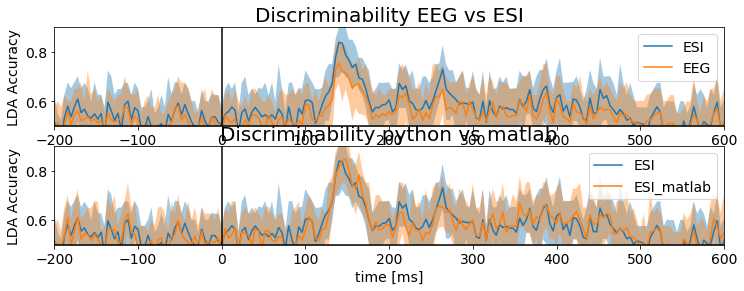

In [52]:
tvec = np.arange(-1500,1000,4)
fig, ax = plt.subplots(2,1,figsize=(12,4))
ax[0].plot(tvec,accuracy.mean(1),label='ESI')
ax[0].fill_between(tvec,np.percentile(accuracy,5,axis=1),np.percentile(accuracy,95,axis=1),alpha = 0.4)
ax[0].plot(tvec,accuracy_eeg.mean(1),label='EEG')
ax[0].fill_between(tvec,np.percentile(accuracy_eeg,5,axis=1),np.percentile(accuracy_eeg,95,axis=1),alpha = 0.4)

ax[0].set_xlim([-200,600])
ax[0].set_ylim([.5,.9])
ax[0].axhline(y=0.50, color='k')
ax[0].axvline(x=0.0, color='k')
ax[0].set_title('Discriminability EEG vs ESI', fontsize=20)
ax[0].set_xlabel('time [ms]',fontsize=14)
ax[0].set_ylabel('LDA Accuracy', fontsize=14)
ax[0].legend(fontsize=14)
ax[0].tick_params(axis="x", labelsize=14)
ax[0].tick_params(axis="y", labelsize=14)

ax[1].plot(tvec,accuracy.mean(1),label='ESI')
ax[1].fill_between(tvec,np.percentile(accuracy,5,axis=1),np.percentile(accuracy,95,axis=1),alpha = 0.4)
ax[1].plot(tvec,accuracy_matlab.mean(1),label='ESI_matlab')
ax[1].fill_between(tvec,np.percentile(accuracy_matlab,5,axis=1),np.percentile(accuracy_matlab,95,axis=1),alpha = 0.4)

ax[1].set_xlim([-200,600])
ax[1].set_ylim([.5,.9])
ax[1].axhline(y=0.50, color='k')
ax[1].axvline(x=0.0, color='k')
ax[1].set_title('Discriminability python vs matlab', fontsize=20)
ax[1].set_xlabel('time [ms]',fontsize=14)
ax[1].set_ylabel('LDA Accuracy', fontsize=14)
ax[1].legend(fontsize=14)
ax[1].tick_params(axis="x", labelsize=14)
ax[1].tick_params(axis="y", labelsize=14)

In [54]:
ESI_matlab_fname = os.path.join(datafold,'02_ESI_CARTOOL','ESI_ROI_FacesTask',subject+'_FACES_250HZ_ESI_ROI_33.mat') 
TCs_1D_matlab = scipy.io.loadmat(ESI_matlab_fname)['ESI_ROI_33']
cort = np.array([i for j in (range(34), range(41, 75)) for i in j])

crossval = 20
nsamples = 625
accuracy_cort = np.zeros((nsamples,crossval))
accuracy_matlab_cort = np.zeros((nsamples,crossval))
TCs_1D_cort = TCs_1D[cort]
TCs_1D_matlab_cort = TCs_1D_matlab[cort]
X1 = TCs_1D_cort[:,:, epochs.events[:,2]==0]
X2 = TCs_1D_cort[:,:, epochs.events[:,2]==1]
X1_matlab = TCs_1D_matlab_cort[:,:, epochs.bevents[:,2]==0]
X2_matlab = TCs_1D_matlab_cort[:,:, epochs.events[:,2]==1]

n1 = len(X1)
n2 = len(X2)
clf = LDA()
import tqdm
for t in tqdm.tqdm(range(nsamples)):
    for cv in range(crossval):
        ids_1 = np.random.permutation(n1)
        ids_2 = np.random.permutation(n2)
        clf.fit(np.concatenate((X1[:,t,ids_1[:int(n1*0.75)]].T,X2[:,t,ids_2[:int(n2*0.75)]].T)), np.concatenate((np.zeros(int(n1*0.75)),np.ones(int(n2*0.75)))))                        
        accuracy_cort[t,cv] = np.mean(clf.predict(np.concatenate((X1[:,t,ids_1[-int(n1*0.25):]].T,X2[:,t,ids_2[-int(n2*0.25):]].T))) == np.concatenate((np.zeros(int(n1*0.25)),np.ones(int(n2*0.25)))))
        clf.fit(np.concatenate((X1_matlab[:,t,ids_1[:int(n1*0.75)]].T,X2_matlab[:,t,ids_2[:int(n2*0.75)]].T)), np.concatenate((np.zeros(int(n1*0.75)),np.ones(int(n2*0.75)))))                        
        accuracy_matlab_cort[t,cv] = np.mean(clf.predict(np.concatenate((X1_matlab[:,t,ids_1[-int(n1*0.25):]].T,X2_matlab[:,t,ids_2[-int(n2*0.25):]].T))) == np.concatenate((np.zeros(int(n1*0.25)),np.ones(int(n2*0.25)))))
        

100%|██████████| 625/625 [01:33<00:00,  6.70it/s]


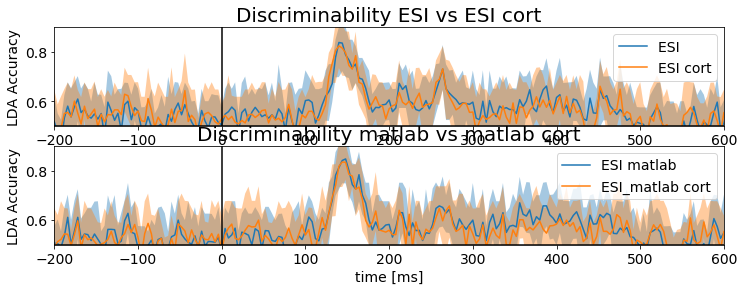

In [55]:
tvec = np.arange(-1500,1000,4)
fig, ax = plt.subplots(2,1,figsize=(12,4))
ax[0].plot(tvec,accuracy.mean(1),label='ESI ')
ax[0].fill_between(tvec,np.percentile(accuracy,5,axis=1),np.percentile(accuracy,95,axis=1),alpha = 0.4)
ax[0].plot(tvec,accuracy_cort.mean(1),label='ESI cort')
ax[0].fill_between(tvec,np.percentile(accuracy_cort,5,axis=1),np.percentile(accuracy_cort,95,axis=1),alpha = 0.4)

ax[0].set_xlim([-200,600])
ax[0].set_ylim([.5,.9])
ax[0].axhline(y=0.50, color='k')
ax[0].axvline(x=0.0, color='k')
ax[0].set_title('Discriminability ESI vs ESI cort', fontsize=20)
ax[0].set_xlabel('time [ms]',fontsize=14)
ax[0].set_ylabel('LDA Accuracy', fontsize=14)
ax[0].legend(fontsize=14)
ax[0].tick_params(axis="x", labelsize=14)
ax[0].tick_params(axis="y", labelsize=14)

ax[1].plot(tvec,accuracy_matlab.mean(1),label='ESI matlab')
ax[1].fill_between(tvec,np.percentile(accuracy_matlab,5,axis=1),np.percentile(accuracy_matlab,95,axis=1),alpha = 0.4)
ax[1].plot(tvec,accuracy_matlab_cort.mean(1),label='ESI_matlab cort')
ax[1].fill_between(tvec,np.percentile(accuracy_matlab_cort,5,axis=1),np.percentile(accuracy_matlab_cort,95,axis=1),alpha = 0.4)

ax[1].set_xlim([-200,600])
ax[1].set_ylim([.5,.9])
ax[1].axhline(y=0.50, color='k')
ax[1].axvline(x=0.0, color='k')
ax[1].set_title('Discriminability matlab vs matlab cort', fontsize=20)
ax[1].set_xlabel('time [ms]',fontsize=14)
ax[1].set_ylabel('LDA Accuracy', fontsize=14)
ax[1].legend(fontsize=14)
ax[1].tick_params(axis="x", labelsize=14)
ax[1].tick_params(axis="y", labelsize=14)

In [ ]:
data_fold = '/Users/joanrue/Documents/PhD/DataAndScripts/data/SINERGIA_2019/'
EEGfiles_path = data_fold+'01_EEG_PREP/Data_FaceTask/' 
list_files = sorted([f for f in os.listdir(EEGfiles_path) if not f.startswith('.')])

counter = 0
crossval = 10
nsamples = 625
accuracy = np.zeros((19,nsamples,crossval))

for sub in list_files:    
    EEG_path = EEGfiles_path+sub+'/'+sub+'_FACES_250HZ_prepd.set'        
    if os.path.exists(EEG_path):        

        # Load EEG data into a 3d array with shape (#trials, #electrodes, # samples)
        Behav_path = EEGfiles_path+sub+'/'+sub+'_FACES_250HZ_behav.txt'


        print('Subject',sub,'\n --> Loading EEG')
        
        EEG_path = EEGfiles_path+sub+'/'+sub+'_FACES_250HZ_prepd.set'
        Behav_path = EEGfiles_path+sub+'/'+sub+'_FACES_250HZ_behav.txt'    
        
        spi_path = data_fold+'02_ESI_CARTOOL/CartoolFiles/sub-'+sub+'/sub-'+sub+'.spi'
        spi_file = pycartool.io.source_space.read_spi(spi_path)
        
        roi_filename = data_fold+'02_ESI_CARTOOL/CartoolFiles/sub-'+sub+'/More/ROI_33/sub-'+sub+'.rois'
        roi_file = pycartool.io.roi.read_roi(roi_filename);
        
        is_filename = data_fold+'02_ESI_CARTOOL/CartoolFiles/sub-'+sub+'/sub-'+sub+'.Laura.is'
        is_file = pycartool.io.inverse_solution.read_is(is_filename)
        IS = is_file['regularisation_solutions'][12]
        
        
        EEGfile = mne.read_epochs_eeglab(EEG_path, events=None, event_id=None, eog=(), verbose=None, uint16_codec=None)
        Behavfile = pd.read_csv(Behav_path, sep=",")
        Behavfile = Behavfile[Behavfile.bad_trials == 0]
        EEGfile.events[:,2] = Behavfile.COND
        EEGfile.event_id = {"Scrambled":0, "Faces":1}
        
        TCs_1D,SCS,nSPI,maindir = project_dipoles_inv3D(EEGfile,roi_file,IS,spi_file,EEGfile.times)
        print('\n --> LDA (10-fold crossvalidation)')
        X1 = np.transpose(TCs_1D[:,:,Behavfile.COND == 0],[2,0,1])
        X2 = np.transpose(TCs_1D[:,:,Behavfile.COND == 1],[2,0,1])
        n1 = len(X1)
        n2 = len(X2)
        clf = LDA()

        for t in range(nsamples):
            for cv in range(crossval):
                ids_1 = np.random.permutation(n1)
                ids_2 = np.random.permutation(n2)         
                clf.fit(np.concatenate((X1[ids_1[:int(n1*0.75)],:,t],X2[ids_2[:int(n2*0.75)],:,t])), np.concatenate((np.zeros(int(n1*0.75)),np.ones(int(n2*0.75)))))                        
                accuracy[counter,t,cv] = np.mean(clf.predict(np.concatenate((X1[ids_1[-int(n1*0.25):],:,t],X2[ids_2[-int(n2*0.25):],:,t]))) == np.concatenate((np.zeros(int(n1*0.25)),np.ones(int(n2*0.25)))))
        counter += 1 


In [ ]:
fig, axs = plt.subplots(6,3,figsize=(20,20))
for i in range(6):
    for j in range(3):
        sub = i*3+j
        axs[i,j].plot(EEGfile.times,accuracy[sub].mean(axis=1))
        axs[i,j].fill_between(EEGfile.times,np.percentile(accuracy[sub],5,axis=1),np.percentile(accuracy[sub],95,axis=1),alpha = 0.5)
        axs[i,j].set_title('Subject %i'% (int(sub)+1))

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(EEGfile.times,accuracy.mean(2).mean(0))
ax.fill_between(EEGfile.times,np.percentile(accuracy.mean(2),5,axis=0),np.percentile(accuracy.mean(2),95,axis=0),alpha = 0.5)
ax.set_title('Al subjects')

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(EEGfile.times,accuracy.mean(2).mean(0))
ax.fill_between(EEGfile.times,np.percentile(accuracy.mean(2),5,axis=0),np.percentile(accuracy.mean(2),95,axis=0),alpha = 0.5)
ax.set_title('Al subjects')
ax.set_xlim([-0.1,0.6])
ax.axhline(y=0.50, color='k')
ax.axvline(x=0.0, color='k')

#### 2.2) Check differences across conditions

In [ ]:
SCS[0].vertices[0]

In [ ]:
mpl_fig = SCS[0].plot(subject='fsaverage',hemi='lh', views='lat', initial_time=0.16,
                   backend='matplotlib', verbose='error')

In [ ]:
# path to subjects' MRI files
#subjects_dir = '/Users/joanrue/Documents/PhD/DataAndScripts/data/SINERGIA_2019/02_ESI_CARTOOL/CartoolFiles/sub-01/More/'


# plot
SCS[0].plot(subject='fsaverage',initial_time=0, hemi='split', views=['lat', 'med'])

#SCS[1].plot(initial_time=0.1, hemi='split', views=['lat', 'med'],
#         subjects_dir=subjects_dir)

### dFC analysis

#### 3.1 dFC estimation

#### 3.2 Check differences across conditions